# Bosques aleatorios

Se basa en generar muchos arboles de decision de manera paralela, tomando como resultados de clasificación la moda de cada árbol independiente. Esta técnica es llamada bagging.

Reduce la varianza de los resultados, lo cual es una debilidad del árbol de decisión.

* https://www.ibm.com/cloud/learn/bagging
* https://www.iartificial.net/ensembles-voting-bagging-boosting-stacking/
* https://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/
* https://machinelearningmastery.com/bagging-and-random-forest-ensemble-algorithms-for-machine-learning/
* https://bookdown.org/content/2031/ensambladores-random-forest-parte-i.html#random-forest

## Implementación

https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients#

### Carga de librerías 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle
import warnings
import seaborn as sns
import timeit
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.tree import export_graphviz
import graphviz
warnings.filterwarnings("ignore")

In [2]:
def plot_confusion_matrix(y_train_pred,y_train,dom,classes):
    print(f'{dom} Confusion matrix')
    cf = confusion_matrix(y_train,y_train_pred)
    sns.heatmap(cf,annot=True,yticklabels=classes
               ,xticklabels=classes,cmap='Blues', fmt='g')
    plt.xlabel("Prediction",fontsize=12,fontweight='bold')
    plt.ylabel("Real",fontsize=12,fontweight='bold')
    plt.tight_layout()
    plt.show()

### Ruta

In [3]:
ruta_input="C:/Users/Omar/Desktop/Omar/Temas data science/Bases/Credit car"

In [4]:
base_input=pd.read_excel(os.path.join(ruta_input,"default of credit card clients.xls"),header=1)

In [5]:
base_input.shape

(30000, 25)

In [6]:
base_input.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [7]:
base_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

### Renombramos dataset 

In [8]:
base_input=base_input.iloc[:,1:]

In [9]:
colum_base=["credito_otorgado($)","genero","educacion","estado_civil","edad","marca_pago_mes_6","marca_pago_mes_5",
            "marca_pago_mes_4","marca_pago_mes_3","marca_pago_mes_2","marca_pago_mes_1","estado_cuenta_mes_6($)",
            "estado_cuenta_mes_5($)","estado_cuenta_mes_4($)","estado_cuenta_mes_3($)","estado_cuenta_mes_2($)",
            "estado_cuenta_mes_1($)","monto_pago_anterior_6($)","monto_pago_anterior_5($)","monto_pago_anterior_4($)",
            "monto_pago_anterior_3($)","monto_pago_anterior_2($)","monto_pago_anterior_1($)","incumplimiento_sgte_mes"]

In [10]:
base_input.columns=colum_base

### featuring engineering  

In [11]:
base_input.loc[base_input['genero']==1,'genero']='masculino'
base_input.loc[base_input['genero']==2,'genero']='femenino'
base_input.loc[(base_input['educacion']>3) | (base_input['educacion']==0),'educacion']='otros'
base_input.loc[base_input['educacion']==1,'educacion']='posgrado'
base_input.loc[base_input['educacion']==2,'educacion']='universidad'
base_input.loc[base_input['educacion']==3,'educacion']='bachillerato'
base_input.loc[(base_input['estado_civil']==3) | (base_input['estado_civil']==0),'estado_civil']='otros'
base_input.loc[base_input['estado_civil']==1,'estado_civil']='casado'
base_input.loc[base_input['estado_civil']==2,'estado_civil']='soltero'

In [12]:
base_dummies=pd.get_dummies(base_input[['genero','educacion','estado_civil']])
base_input=pd.concat([base_input,base_dummies],axis=1)
base_input.drop(columns=["genero","educacion","estado_civil","edad"],inplace=True)

**Estandarización**

In [13]:
base=base_input.copy()
X=base_input.drop(columns=["incumplimiento_sgte_mes"])

In [14]:
Y=base_input[["incumplimiento_sgte_mes"]]
Y['incumplimiento_sgte_mes']=Y['incumplimiento_sgte_mes'].apply(int)

In [15]:
scaler = MinMaxScaler()
X_scaler = scaler.fit_transform(X)
X_scaler = pd.DataFrame(X_scaler)
X_scaler.columns = X.columns

### Train y test para el modelo

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_scaler, Y, test_size=0.3, random_state=213)
columns = X_train.columns

###  Balanceo

In [17]:
bal = SMOTE(random_state=23)
databal_X,databal_y= bal.fit_resample(X_train, y_train.values.ravel())
columns=X_train.columns.to_list()
databal_X = pd.DataFrame(data=databal_X,columns=columns )
databal_y= pd.DataFrame(data=databal_y,columns=['y'])

print("Tamaño de X_train: ",len(X_train))
print("Tamaño de bal_data_x: ",len(databal_X))

Tamaño de X_train:  21000
Tamaño de bal_data_x:  32646


In [18]:
print("cantidad de registros 0:",len(databal_y[databal_y['y']==0]))
print("cantidad de registros 1:",len(databal_y[databal_y['y']==1]))

cantidad de registros 0: 16323
cantidad de registros 1: 16323


In [19]:
X_trainbal=databal_X.copy()
y_trainbal=databal_y.copy()

### Implementación del modelo

**Sklearn**

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

En primer lugar, generaremos un random forest sin mayor restricción en hiperparámetros

In [20]:
random_f1=RandomForestClassifier(n_estimators=100, n_jobs = -1, random_state=220)

In [21]:
start_time = timeit.default_timer()
model_1 = random_f1.fit(X_trainbal,y_trainbal)
elapsed = timeit.default_timer() - start_time

In [22]:
print("La ejecución fue de: ",elapsed/60)

La ejecución fue de:  0.07845268833333335


In [23]:
predict_train_1=model_1.predict(X_train)
predict_test_1=model_1.predict(X_test)

In [24]:
print("Train")
print(classification_report(y_train, predict_train_1))

Train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16323
           1       0.99      0.99      0.99      4677

    accuracy                           0.99     21000
   macro avg       0.99      0.99      0.99     21000
weighted avg       0.99      0.99      0.99     21000



In [25]:
print("Test")
print(classification_report(y_test, predict_test_1))

Test
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      7041
           1       0.54      0.48      0.51      1959

    accuracy                           0.80      9000
   macro avg       0.70      0.68      0.69      9000
weighted avg       0.79      0.80      0.79      9000



Notamos que el modelo a **sobreajustado** al conjunto de entrenamiento.

Graficando un solo arbol

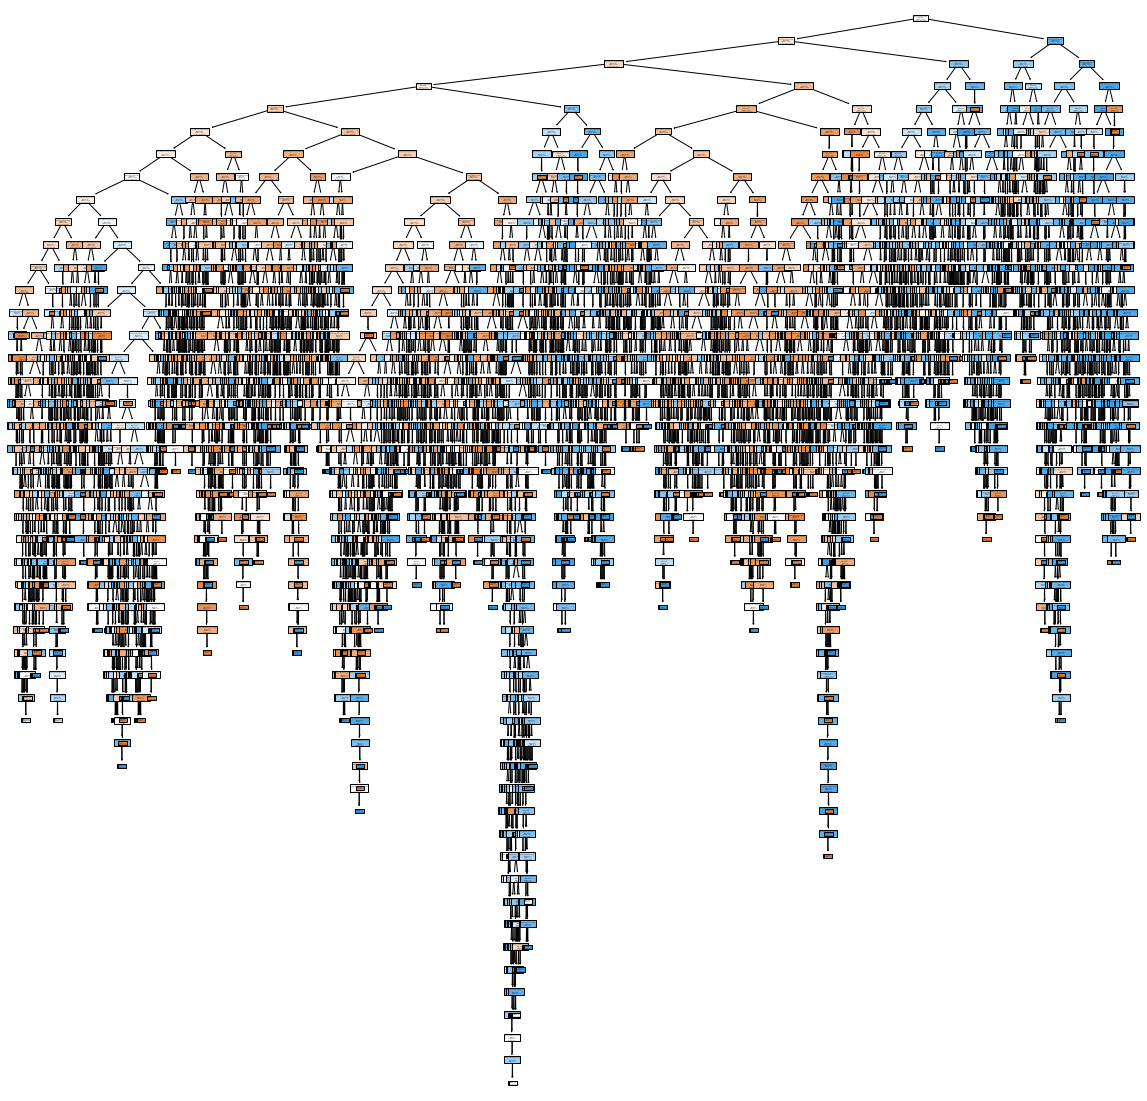

In [26]:
plt.figure(figsize=(20,20))
_ = tree.plot_tree(model_1.estimators_[0], feature_names=X_train.columns, filled=True)

## Tuning de hiperparametros

Aquí definiremos los posibles valores de los hiperparámetros para evitar el sobreajuste.

* max_depth: maximum depth of decision tree
* min_sample_split: The minimum number of samples required to split an internal node:
* min_samples_leaf: The minimum number of samples required to be at a leaf node.
* max_features: número de variables a considerar en el random forest.

In [27]:
random_f2=RandomForestClassifier(n_estimators=100, criterion= "gini", n_jobs = -1, random_state=245)

In [28]:
params = {'max_depth': [2,3,4],
         'min_samples_split': [50,60],
         'min_samples_leaf': [10,20],
         'max_features': [0.4]}
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=808)

In [29]:
model_2 = GridSearchCV(estimator=random_f2,param_grid=params,n_jobs=-1, cv=cv, scoring='f1')

start_time = timeit.default_timer()
model_2.fit(X_trainbal,y_trainbal)
elapsed_3 = timeit.default_timer() - start_time

In [30]:
print("La ejecución fue de: ",elapsed_3/60)

La ejecución fue de:  3.3234166283333337


Veamos el resultado

In [31]:
means = model_2.cv_results_['mean_test_score']
stds = model_2.cv_results_['std_test_score']
params = model_2.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("Promedio del score es %f, con std de: (%f), y parametros: %r" % (mean, stdev, param))

Promedio del score es 0.648055, con std de: (0.005015), y parametros: {'max_depth': 2, 'max_features': 0.4, 'min_samples_leaf': 10, 'min_samples_split': 50}
Promedio del score es 0.648055, con std de: (0.005015), y parametros: {'max_depth': 2, 'max_features': 0.4, 'min_samples_leaf': 10, 'min_samples_split': 60}
Promedio del score es 0.648067, con std de: (0.005021), y parametros: {'max_depth': 2, 'max_features': 0.4, 'min_samples_leaf': 20, 'min_samples_split': 50}
Promedio del score es 0.648067, con std de: (0.005021), y parametros: {'max_depth': 2, 'max_features': 0.4, 'min_samples_leaf': 20, 'min_samples_split': 60}
Promedio del score es 0.663735, con std de: (0.004174), y parametros: {'max_depth': 3, 'max_features': 0.4, 'min_samples_leaf': 10, 'min_samples_split': 50}
Promedio del score es 0.663759, con std de: (0.004166), y parametros: {'max_depth': 3, 'max_features': 0.4, 'min_samples_leaf': 10, 'min_samples_split': 60}
Promedio del score es 0.663711, con std de: (0.004166), y 

In [32]:
model_2.best_estimator_

RandomForestClassifier(max_depth=4, max_features=0.4, min_samples_leaf=20,
                       min_samples_split=60, n_jobs=-1, random_state=245)

**Analizando desempeño**

In [33]:
predict_train_2=model_2.predict(X_train)
predict_test_2=model_2.predict(X_test)

In [34]:
print("Train")
print(classification_report(y_train, predict_train_2))

Train
              precision    recall  f1-score   support

           0       0.87      0.86      0.86     16323
           1       0.53      0.56      0.54      4677

    accuracy                           0.79     21000
   macro avg       0.70      0.71      0.70     21000
weighted avg       0.79      0.79      0.79     21000



In [35]:
print("Test")
print(classification_report(y_test, predict_test_2))

Test
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      7041
           1       0.52      0.54      0.53      1959

    accuracy                           0.79      9000
   macro avg       0.69      0.70      0.70      9000
weighted avg       0.79      0.79      0.79      9000



In [36]:
from sklearn.metrics import confusion_matrix
labels = np.array([0, 1])
confusion_matrix_2 = confusion_matrix(y_test, predict_test_2, labels = labels)
pd.DataFrame(confusion_matrix_2, index = labels, columns = labels)

,0,1
0,6041,1000
1,895,1064


Test Confusion matrix


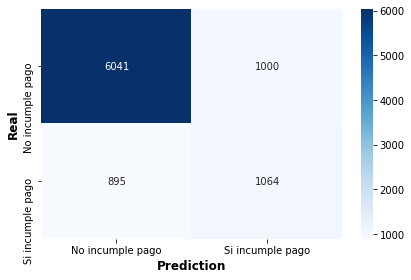

In [37]:
classes = ['No incumple pago','Si incumple pago']
plot_confusion_matrix(predict_test_2,y_test,dom='Test',classes=classes)

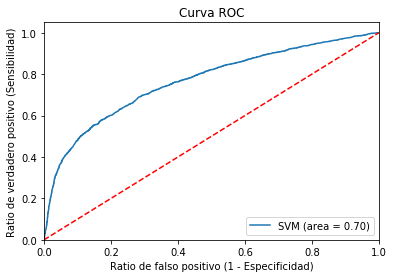

In [38]:
curva_roc = roc_auc_score(y_test, model_2.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, model_2.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='SVM (area = %0.2f)' % curva_roc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Ratio de falso positivo (1 - Especificidad)')
plt.ylabel('Ratio de verdadero positivo (Sensibilidad)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.savefig('Curva_roc')
plt.show()

**Graficando árbol**

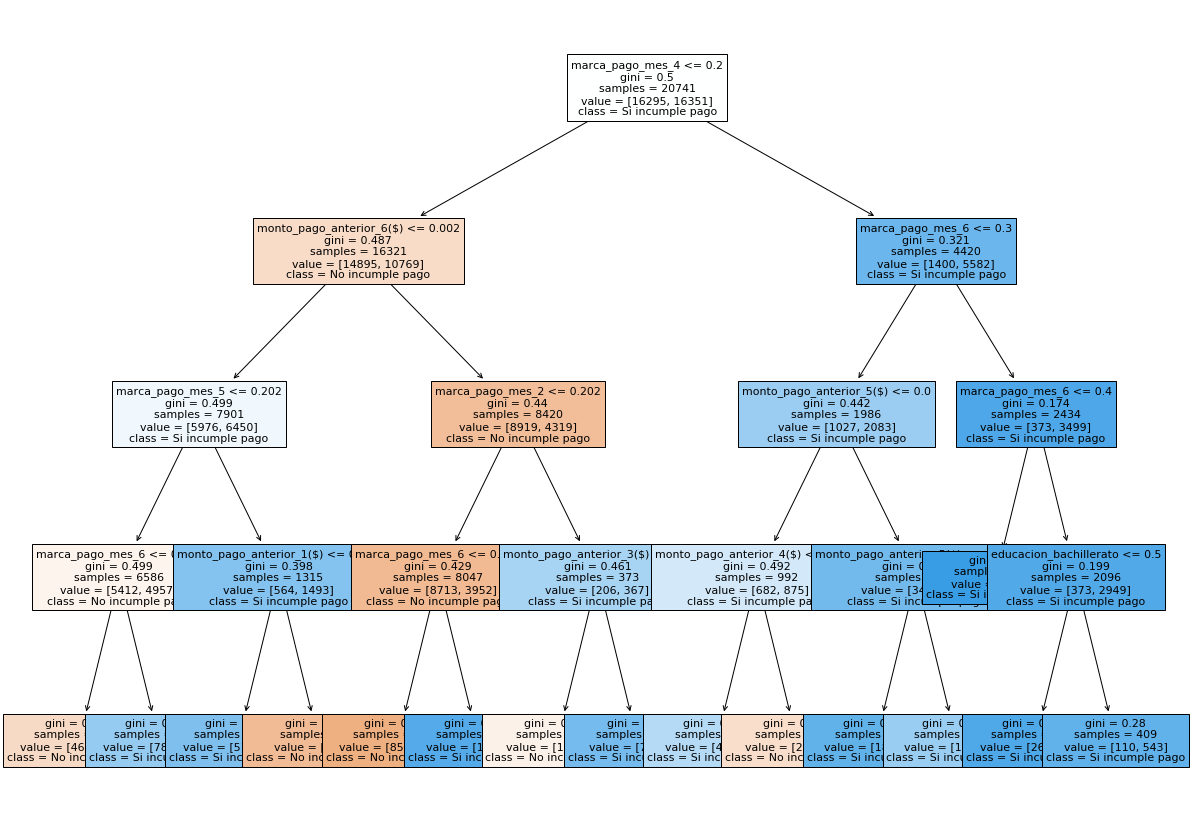

In [39]:
plt.figure(figsize=(20,15))
features=X_train.columns
tree.plot_tree(model_2.best_estimator_.estimators_[86],filled = True,feature_names=features,class_names=classes,fontsize=11)
plt.show()

**Variables importantes**

In [40]:
variables_importantes_2=model_2.best_estimator_.feature_importances_

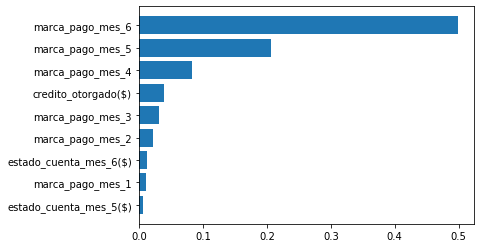

In [41]:
graf= pd.DataFrame(variables_importantes_2,X_train.columns)
graf.rename(columns={0:'valor'},inplace=True)
graf.sort_values('valor')
graf=graf.iloc[:-19]
graf=graf.sort_values('valor')
plt.barh(graf.index,graf['valor'])
plt.show()

In [42]:
graf.sort_values('valor',ascending=False)

,valor
marca_pago_mes_6,0.498636
marca_pago_mes_5,0.205761
marca_pago_mes_4,0.083141
credito_otorgado($),0.039735
marca_pago_mes_3,0.030843
marca_pago_mes_2,0.021340
estado_cuenta_mes_6($),0.012939
marca_pago_mes_1,0.010494
estado_cuenta_mes_5($),0.006029


Vemos que la variable **"marca_pago_mes_6"** es la variable que aporta más al modelo.

In [43]:
from sklearn.metrics import confusion_matrix
labels = np.array([0, 1])

confusion_matrix_0 = confusion_matrix(y_train, predict_train_2, labels = labels)
confusion_matrix_1 = confusion_matrix(y_test, predict_test_2, labels = labels)
##
acc_0=(confusion_matrix_0[0][0]+confusion_matrix_0[1][1])/(confusion_matrix_0[0][0]+confusion_matrix_0[0][1]+confusion_matrix_0[1][0]+confusion_matrix_0[1][1])
acc=(confusion_matrix_1[0][0]+confusion_matrix_1[1][1])/(confusion_matrix_1[0][0]+confusion_matrix_1[0][1]+confusion_matrix_1[1][0]+confusion_matrix_1[1][1])
##
prec_0=(confusion_matrix_0[1][1])/(confusion_matrix_0[1][1]+confusion_matrix_0[0][1])
prec=(confusion_matrix_1[1][1])/(confusion_matrix_1[1][1]+confusion_matrix_1[0][1])
##
sens_0=(confusion_matrix_0[1][1])/(confusion_matrix_0[1][1]+confusion_matrix_0[1][0])
sens=(confusion_matrix_1[1][1])/(confusion_matrix_1[1][1]+confusion_matrix_1[1][0])
##
f1_score=2*(sens*prec)/(sens+prec)
f1_score_0=2*(sens_0*prec_0)/(sens_0+prec_0)
##
beta=2
f2_score=(1+beta**2)*((sens*prec)/(beta**2*prec+sens))
f2_score_0=(1+beta**2)*((sens_0*prec_0)/(beta**2*prec_0+sens_0))
##
curva_roc_0 = roc_auc_score(y_train, model_2.predict(X_train))

In [44]:
Tabla=pd.DataFrame({"Etapa":["Train","Test"],"Modelo":["Random forest","Random forest"],"Accuracy":[acc_0,acc],
                    "Precision":[prec_0,prec],"Sensibility":[sens_0,sens],
                    "F1 Score":[f1_score_0,f1_score],"F2 Score":[f2_score_0,f2_score],
                    "AUC":[curva_roc_0,curva_roc],"Gini":[2*curva_roc_0-1,2*curva_roc-1]})
Tabla

,Etapa,Modelo,Accuracy,Precision,Sensibility,F1 Score,F2 Score,AUC,Gini
0,Train,Random forest,0.789857,0.526688,0.556981,0.541411,0.550647,0.706782,0.413564
1,Test,Random forest,0.789444,0.515504,0.543134,0.528958,0.537374,0.700554,0.401109


### FIN